In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-13 01:35:29.625645: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-13 01:35:43.107762: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-13 01:35:43.120495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-13 01:35:43.120528: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-13 01:35:43.123228: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-13 01:35:43.125883: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


- $\frac{\partial u^*}{\partial t^*} =  (\partial_{x^* x^*} + \partial_{y^* y^*}) u^* + \rho^*_u \frac{(u^*)^2 v^*}{1 + \kappa_u (u^*)^2} - u^* + 1$
- $\frac{\partial v^*}{\partial t^*} =  D (\partial_{x^* x^*} + \partial_{y^* y^*}) v^*- \rho^*_v \frac{(u^*)^2 v^*}{1 + \kappa_u^* (u^*)^2} + 1$

- $  u = (\sigma_u/\mu_u) u^*$
- $  v = (\sigma_v/\mu_u) v^*$
- $  t = t^*/ \mu_u$
- $  x = \sqrt{\frac{D_u}{\mu_u}} x^*$
- $  y = \sqrt{\frac{D_u}{\mu_u}} y^*$
- $  D = \frac{D_v}{D_u}$
- $  \rho_u = (\frac{\mu_u^3}{\sigma_u \sigma_v}) \rho^*_u$
- $  \rho_v = (\frac{\mu_u^3}{\sigma_u^2}) \rho^*_v$
- $  \kappa_u = (\frac{\mu_u^2}{\sigma_u^2}) \kappa_u^*$

In [5]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)
# Transfer t to t*
t_star *= simulation.parameters["mu_u"]
# Transfer u to u*
data[0, ...] *= simulation.parameters["mu_u"]/simulation.parameters["sigma_u"]  
# Transfer v to v*
data[1, ...] *= simulation.parameters["mu_u"]/simulation.parameters["sigma_v"]  

pre_data = data[..., -4:-3]
post_data = data[..., -1:]
post_t_star = t_star[-1:]
t_star = t_star[-3:-1]
data = data[..., -3:-1]
T = t_star.shape[0]    
    
# Make sure L is equal to L * sqrt(mu_u/D_u)
#L = simulation.L[0]
L = simulation.L[0]* np.sqrt(simulation.parameters["mu_u"]/simulation.Ds[0])
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

#
D = simulation.Ds[1]/simulation.Ds[0]
kappa_u = simulation.parameters["kappa_u"]*(simulation.parameters["sigma_u"]/simulation.parameters["mu_u"])**2
rho_u = simulation.parameters["rho_u"]*(simulation.parameters["sigma_u"]*simulation.parameters["sigma_v"]/simulation.parameters["mu_u"]**3)
rho_v = simulation.parameters["rho_v"]*(simulation.parameters["sigma_u"]**2/simulation.parameters["mu_u"]**3)


In [6]:
pre_data.shape

(2, 100, 100, 1)

In [7]:
post_data.shape

(2, 100, 100, 1)

In [8]:
data.shape

(2, 100, 100, 2)

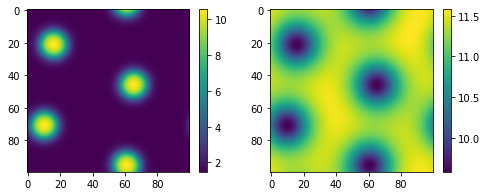

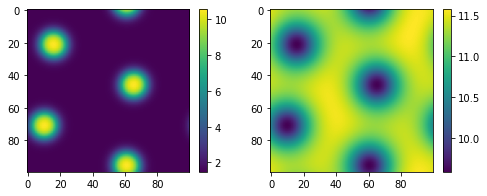

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [10]:
simulation.Ds

(0.01, 1.0)

In [11]:
data.shape

(2, 100, 100, 2)

In [12]:
dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[(10 if c==1 else 1)* dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[(10 if c==1 else 1)* dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
c_t = np.array([[((data[c, ..., t+1] if t+1 < data.shape[3] else post_data[c, ..., 0]) -  data[c, ..., t]
                 )/(t_star[t+1] if t+1 < data.shape[3] else post_t_star[0] - t_star[t])
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [13]:
c_t.shape

(2, 100, 100, 2)

In [14]:
c_yy.shape

(2, 100, 100, 2)

In [15]:
T

2

In [16]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[(10 if c==1 else 1)* dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [17]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
indices_sub = indices_all[:, 30:65, 50:85]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb'][:2]
ub = dataset['ub'][:2]

obs_inputs = dataset['obs_input'][:,:2]#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output'][:,:2]#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T[:,:2]#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T[:,:2]#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
# der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [18]:
obs_X.shape

(2450, 8)

In [19]:
c_xx.shape

(2, 100, 100, 2)

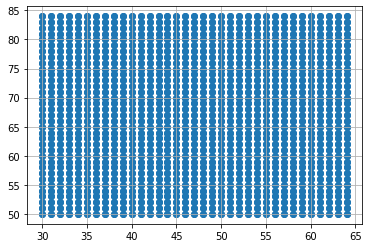

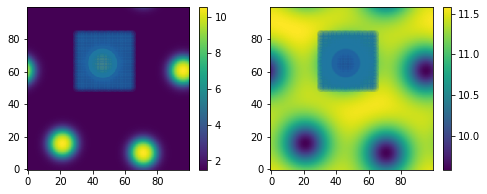

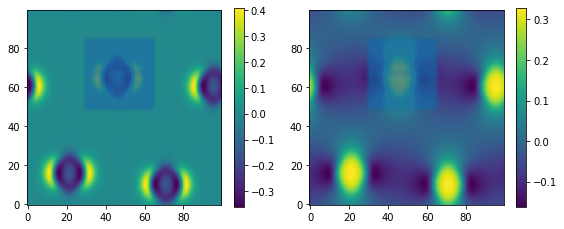

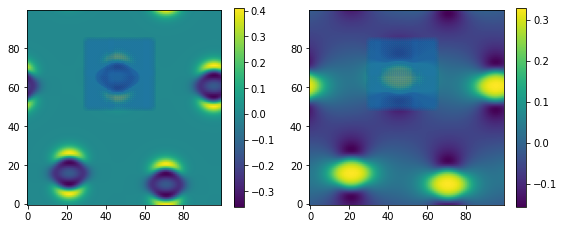

In [20]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.05)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.05)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.05)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.05)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.05)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.05)
plt.tight_layout()
plt.show()


In [21]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, pde_X)

In [22]:
ds_obs.sizes

array([2450, 2450])

In [23]:
layers = [2, 1024, 1024, 1024, 6]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
#layers = [2, 32, 32, 32, 32, 2]

pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard_Dimensionless_steady_output_as_Der(
                    dtype = pinnKM.dtype,
                    #D=PDE_Parameter("D", Parameter_Type.VARIABLE, 10.0,dtype=pinnKM.dtype),
                    D=PDE_Parameter("D", Parameter_Type.CONSTANT, 
                                    10.0,#D, 
                                    dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, 
                    #                      kappa_u,
                    #                      dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, 
                    #                    rho_u,
                    #                    dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, 
                    #                    rho_v,
                    #                    dtype=pinnKM.dtype),
    regularise=False
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
obs_loss = Observation_Loss(layers=layers,  
                           residual_ret_names=("u", "v", "u_xx", "u_yy",  "v_xx", "v_yy"))
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
#der_loss = All_Derivatives_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
#                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [30]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)
modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 97000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)
modelKM.optimizer.lr.assign(5e-5)
results_KM3 = modelKM.train(epochs = 100000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0


2022-12-13 01:40:34.234384: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


total loss: 1210.542114257812, total regularised loss: 1210.542114257812
Observation_Loss -> 
(1)  u: 14.982281722128 (2)  v: 100.533326148987 (3)  u_xx: 0.031609909667 
(4)  u_yy: 0.041122815281 (5)  v_xx: 0.041773821999 (6)  v_yy: 0.034516817919 

Loss_Koch_Meinhard -> 
(7)  res u: 0.534397164360 (8)  res v: 4.855183912441 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 

rho_u: 0.99598 rho_v: 0.99968 kappa_u: 1.00106 
Time taken: 4.09s

Start of epoch 1000
total loss: 47.335375070572, total regularised loss: 87.466972351074
Observation_Loss -> 
(1)  u: 1.402342449874 (2)  v: 1.575161829125 (3)  u_xx: 0.506206626073 
(4)  u_yy: 0.386809431948 (5)  v_xx: 0.108425903658 (6)  v_yy: 0.254455433693 

Loss_Koch_Meinhard -> 
(7)  res u: 0.157354820287 (8)  res v: 0.342780988663 
(1) lambdas : 5.102585792542 (2) lambdas : 0.577361345291 (3) lambdas : 0.167729765177 


Start of epoch 11000
total loss: 0.015042827814, total regularised loss: 0.015528691001
Observation_Loss -> 
(1)  u: 0.000280593158 (2)  v: 0.000155057508 (3)  u_xx: 0.000159050865 
(4)  u_yy: 0.000140343751 (5)  v_xx: 0.000171140051 (6)  v_yy: 0.000178678234 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000241379497 (8)  res v: 0.000178039752 
(1) lambdas : 1.484252214432 (2) lambdas : 1.095763444901 (3) lambdas : 1.321542739868 
(4) lambdas : 0.909333348274 (5) lambdas : 0.620552420616 (6) lambdas : 0.568555712700 

rho_u: 0.01959 rho_v: 0.01454 kappa_u: 0.01012 
Time taken: 138.67s

Start of epoch 12000
total loss: 0.038117161021, total regularised loss: 0.096962511539
Observation_Loss -> 
(1)  u: 0.001823141552 (2)  v: 0.000253001797 (3)  u_xx: 0.000300339301 
(4)  u_yy: 0.000255428074 (5)  v_xx: 0.000191490419 (6)  v_yy: 0.000198443379 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000416846055 (8)  res v: 0.000373025636 
(1) lambdas : 4.726863861084 (2) lambdas : 0.346077471972 (3) lambdas : 0


Start of epoch 25000
total loss: 0.091309741838, total regularised loss: 0.328684389591
Observation_Loss -> 
(1)  u: 0.006512512497 (2)  v: 0.000150129653 (3)  u_xx: 0.000134219992 
(4)  u_yy: 0.000101898225 (5)  v_xx: 0.000088027754 (6)  v_yy: 0.000082787781 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000204306913 (8)  res v: 0.001857091455 
(1) lambdas : 4.836580753326 (2) lambdas : 0.225672885776 (3) lambdas : 0.253111273050 
(4) lambdas : 0.223926514387 (5) lambdas : 0.228878557682 (6) lambdas : 0.231830462813 

rho_u: 0.01958 rho_v: 0.01459 kappa_u: 0.01014 
Time taken: 132.64s

Start of epoch 26000
total loss: 0.005549467780, total regularised loss: 0.005671767052
Observation_Loss -> 
(1)  u: 0.000104580393 (2)  v: 0.000049968558 (3)  u_xx: 0.000055294473 
(4)  u_yy: 0.000051459017 (5)  v_xx: 0.000066075813 (6)  v_yy: 0.000069309175 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000097157263 (8)  res v: 0.000061102102 
(1) lambdas : 1.339041948318 (2) lambdas : 0.954266786575 (3) lambdas : 1


Start of epoch 39000
total loss: 0.011277788057, total regularised loss: 0.012307206169
Observation_Loss -> 
(1)  u: 0.000088185645 (2)  v: 0.000040224455 (3)  u_xx: 0.000046075745 
(4)  u_yy: 0.000043359675 (5)  v_xx: 0.000053492033 (6)  v_yy: 0.000054214048 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000092862292 (8)  res v: 0.000709364940 
(1) lambdas : 3.246990442276 (2) lambdas : 0.378752261400 (3) lambdas : 0.560906469822 
(4) lambdas : 0.486106663942 (5) lambdas : 0.725773155689 (6) lambdas : 0.601470828056 

rho_u: 0.01955 rho_v: 0.01480 kappa_u: 0.01009 
Time taken: 136.44s

Start of epoch 40000
total loss: 0.819488793146, total regularised loss: 0.820713162422
Observation_Loss -> 
(1)  u: 0.000518545730 (2)  v: 0.000225043465 (3)  u_xx: 0.000229898293 
(4)  u_yy: 0.000235111260 (5)  v_xx: 0.000225723790 (6)  v_yy: 0.000171379586 

Loss_Koch_Meinhard -> 
(7)  res u: 0.004022028959 (8)  res v: 0.076321150380 
(1) lambdas : 1.472477078438 (2) lambdas : 0.663416564465 (3) lambdas : 1


Start of epoch 53000
total loss: 0.004110292852, total regularised loss: 0.004290087614
Observation_Loss -> 
(1)  u: 0.000080434133 (2)  v: 0.000033395670 (3)  u_xx: 0.000040564060 
(4)  u_yy: 0.000039793456 (5)  v_xx: 0.000048896141 (6)  v_yy: 0.000052164399 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000071648662 (8)  res v: 0.000044132763 
(1) lambdas : 1.512207269669 (2) lambdas : 0.798030495644 (3) lambdas : 1.084116220474 
(4) lambdas : 1.059308290482 (5) lambdas : 0.797022283077 (6) lambdas : 0.749315500259 

rho_u: 0.01957 rho_v: 0.01474 kappa_u: 0.01010 
Time taken: 138.05s

Start of epoch 54000
total loss: 0.018919723690, total regularised loss: 0.052235201001
Observation_Loss -> 
(1)  u: 0.001050381482 (2)  v: 0.000045426080 (3)  u_xx: 0.000056143575 
(4)  u_yy: 0.000053468492 (5)  v_xx: 0.000055929922 (6)  v_yy: 0.000054802834 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000120826783 (8)  res v: 0.000454993302 
(1) lambdas : 4.491287231445 (2) lambdas : 0.219351172447 (3) lambdas : 0


Start of epoch 67000
total loss: 0.003797524929, total regularised loss: 0.003989002202
Observation_Loss -> 
(1)  u: 0.000078377827 (2)  v: 0.000030086526 (3)  u_xx: 0.000037101885 
(4)  u_yy: 0.000035339262 (5)  v_xx: 0.000045316004 (6)  v_yy: 0.000046889068 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000064240543 (8)  res v: 0.000042401383 
(1) lambdas : 1.457960128784 (2) lambdas : 0.660049974918 (3) lambdas : 1.179990053177 
(4) lambdas : 0.963469982147 (5) lambdas : 0.922048091888 (6) lambdas : 0.816481769085 

rho_u: 0.01956 rho_v: 0.01476 kappa_u: 0.01008 
Time taken: 139.70s

Start of epoch 68000
total loss: 0.003717381711, total regularised loss: 0.003801280167
Observation_Loss -> 
(1)  u: 0.000079706946 (2)  v: 0.000028992885 (3)  u_xx: 0.000036347869 
(4)  u_yy: 0.000033959087 (5)  v_xx: 0.000043940579 (6)  v_yy: 0.000044993418 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000063682219 (8)  res v: 0.000040115173 
(1) lambdas : 1.207084178925 (2) lambdas : 0.547598063946 (3) lambdas : 1


Start of epoch 81000
total loss: 0.003634217515, total regularised loss: 0.003736339277
Observation_Loss -> 
(1)  u: 0.000077321449 (2)  v: 0.000030881734 (3)  u_xx: 0.000035361641 
(4)  u_yy: 0.000033049368 (5)  v_xx: 0.000043846827 (6)  v_yy: 0.000043767291 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000060338052 (8)  res v: 0.000038855399 
(1) lambdas : 1.283229827881 (2) lambdas : 0.831508159637 (3) lambdas : 1.195004105568 
(4) lambdas : 1.002543091774 (5) lambdas : 0.890163779259 (6) lambdas : 0.797550916672 

rho_u: 0.01956 rho_v: 0.01477 kappa_u: 0.01008 
Time taken: 134.51s

Start of epoch 82000
total loss: 0.003469099887, total regularised loss: 0.003556216368
Observation_Loss -> 
(1)  u: 0.000079970862 (2)  v: 0.000026811283 (3)  u_xx: 0.000033940635 
(4)  u_yy: 0.000030477165 (5)  v_xx: 0.000040254472 (6)  v_yy: 0.000041116756 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000057237513 (8)  res v: 0.000037101307 
(1) lambdas : 1.147632122040 (2) lambdas : 0.589252769947 (3) lambdas : 1


Start of epoch 95000
total loss: 0.003224679982, total regularised loss: 0.003365571611
Observation_Loss -> 
(1)  u: 0.000069069897 (2)  v: 0.000024880286 (3)  u_xx: 0.000032008696 
(4)  u_yy: 0.000028271283 (5)  v_xx: 0.000038226312 (6)  v_yy: 0.000040054625 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000053337063 (8)  res v: 0.000036619850 
(1) lambdas : 1.322903513908 (2) lambdas : 0.553363502026 (3) lambdas : 1.533915162086 
(4) lambdas : 0.823507428169 (5) lambdas : 0.923477292061 (6) lambdas : 0.842833042145 

rho_u: 0.01954 rho_v: 0.01479 kappa_u: 0.01005 
Time taken: 139.64s

Start of epoch 96000
total loss: 0.003675216052, total regularised loss: 0.003830613568
Observation_Loss -> 
(1)  u: 0.000068519518 (2)  v: 0.000025424838 (3)  u_xx: 0.000033193179 
(4)  u_yy: 0.000028926189 (5)  v_xx: 0.000039176064 (6)  v_yy: 0.000040449907 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000060885264 (8)  res v: 0.000070946653 
(1) lambdas : 1.375889420509 (2) lambdas : 0.434770792723 (3) lambdas : 1


Start of epoch 12000
total loss: 0.004096691904, total regularised loss: 0.009457113221
Observation_Loss -> 
(1)  u: 0.000206993339 (2)  v: 0.000022062885 (3)  u_xx: 0.000026547626 
(4)  u_yy: 0.000024586263 (5)  v_xx: 0.000024896210 (6)  v_yy: 0.000025301336 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000048226826 (8)  res v: 0.000031054718 
(1) lambdas : 3.989677190781 (2) lambdas : 0.279969096184 (3) lambdas : 0.450996220112 
(4) lambdas : 0.376404017210 (5) lambdas : 0.482479512691 (6) lambdas : 0.420474112034 

rho_u: 0.01953 rho_v: 0.01496 kappa_u: 0.01004 
Time taken: 136.31s

Start of epoch 13000
total loss: 0.002290233184, total regularised loss: 0.002354635624
Observation_Loss -> 
(1)  u: 0.000052960298 (2)  v: 0.000019706911 (3)  u_xx: 0.000023352983 
(4)  u_yy: 0.000021464177 (5)  v_xx: 0.000024039073 (6)  v_yy: 0.000024421898 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000038981713 (8)  res v: 0.000024096272 
(1) lambdas : 1.148529052734 (2) lambdas : 0.568285465240 (3) lambdas : 1


Start of epoch 26000
total loss: 0.002009732489, total regularised loss: 0.002094426425
Observation_Loss -> 
(1)  u: 0.000047757440 (2)  v: 0.000017533393 (3)  u_xx: 0.000020286042 
(4)  u_yy: 0.000018846881 (5)  v_xx: 0.000020739883 (6)  v_yy: 0.000021029362 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000033865953 (8)  res v: 0.000020914300 
(1) lambdas : 1.252169609070 (2) lambdas : 0.660444736481 (3) lambdas : 1.151803493500 
(4) lambdas : 0.848695755005 (5) lambdas : 1.175443768501 (6) lambdas : 0.911442518234 

rho_u: 0.01952 rho_v: 0.01496 kappa_u: 0.01003 
Time taken: 138.78s

Start of epoch 27000
total loss: 0.001974036117, total regularised loss: 0.002062772168
Observation_Loss -> 
(1)  u: 0.000045339143 (2)  v: 0.000017242628 (3)  u_xx: 0.000020152608 
(4)  u_yy: 0.000018797168 (5)  v_xx: 0.000020540731 (6)  v_yy: 0.000020857050 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000033789423 (8)  res v: 0.000020684863 
(1) lambdas : 1.293732047081 (2) lambdas : 0.625808954239 (3) lambdas : 1


Start of epoch 40000
total loss: 0.123452945147, total regularised loss: 0.165359824896
Observation_Loss -> 
(1)  u: 0.002750740769 (2)  v: 0.000066907438 (3)  u_xx: 0.000068472636 
(4)  u_yy: 0.000047375899 (5)  v_xx: 0.000046709896 (6)  v_yy: 0.000028228381 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000305883986 (8)  res v: 0.009030976013 
(1) lambdas : 2.896459817886 (2) lambdas : 0.466173529625 (3) lambdas : 0.721470952034 
(4) lambdas : 0.640146315098 (5) lambdas : 0.707686185837 (6) lambdas : 0.568063080311 

rho_u: 0.01951 rho_v: 0.01494 kappa_u: 0.01006 
Time taken: 135.09s

Start of epoch 41000
total loss: 0.001836632073, total regularised loss: 0.001880869153
Observation_Loss -> 
(1)  u: 0.000047843420 (2)  v: 0.000015990257 (3)  u_xx: 0.000017808456 
(4)  u_yy: 0.000016956550 (5)  v_xx: 0.000017998845 (6)  v_yy: 0.000018462314 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000030069215 (8)  res v: 0.000018534151 
(1) lambdas : 1.120346784592 (2) lambdas : 0.583903312683 (3) lambdas : 1


Start of epoch 54000
total loss: 0.030078814845, total regularised loss: 0.030183527619
Observation_Loss -> 
(1)  u: 0.000038729316 (2)  v: 0.000022609594 (3)  u_xx: 0.000023228450 
(4)  u_yy: 0.000023244658 (5)  v_xx: 0.000021300061 (6)  v_yy: 0.000021765917 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000259548059 (8)  res v: 0.002597455555 
(1) lambdas : 1.672617197037 (2) lambdas : 0.577113330364 (3) lambdas : 1.025155186653 
(4) lambdas : 0.850367665291 (5) lambdas : 1.072622060776 (6) lambdas : 0.802124798298 

rho_u: 0.01950 rho_v: 0.01493 kappa_u: 0.01005 
Time taken: 132.46s

Start of epoch 55000
total loss: 0.034811134479, total regularised loss: 0.034988522530
Observation_Loss -> 
(1)  u: 0.000039514101 (2)  v: 0.000024249793 (3)  u_xx: 0.000024825137 
(4)  u_yy: 0.000025357319 (5)  v_xx: 0.000022049301 (6)  v_yy: 0.000021914901 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000337178506 (8)  res v: 0.002986024489 
(1) lambdas : 2.084402561188 (2) lambdas : 0.537651300430 (3) lambdas : 0


Start of epoch 68000
total loss: 0.001508254121, total regularised loss: 0.001562110614
Observation_Loss -> 
(1)  u: 0.000035708009 (2)  v: 0.000013521388 (3)  u_xx: 0.000015109044 
(4)  u_yy: 0.000014491421 (5)  v_xx: 0.000015093675 (6)  v_yy: 0.000015434158 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000025484550 (8)  res v: 0.000015983169 
(1) lambdas : 1.230795621872 (2) lambdas : 0.665011942387 (3) lambdas : 1.166602492332 
(4) lambdas : 0.930352926254 (5) lambdas : 1.205319046974 (6) lambdas : 0.801918029785 

rho_u: 0.01952 rho_v: 0.01495 kappa_u: 0.01002 
Time taken: 140.08s

Start of epoch 69000
total loss: 0.002179905481, total regularised loss: 0.002624767832
Observation_Loss -> 
(1)  u: 0.000037357131 (2)  v: 0.000013990847 (3)  u_xx: 0.000016036644 
(4)  u_yy: 0.000015474798 (5)  v_xx: 0.000015387272 (6)  v_yy: 0.000015672346 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000030524748 (8)  res v: 0.000073546772 
(1) lambdas : 2.828332662582 (2) lambdas : 0.388500958681 (3) lambdas : 0


Start of epoch 82000
total loss: 0.001493342694, total regularised loss: 0.001540188445
Observation_Loss -> 
(1)  u: 0.000035090005 (2)  v: 0.000012429476 (3)  u_xx: 0.000013707914 
(4)  u_yy: 0.000013424425 (5)  v_xx: 0.000013664683 (6)  v_yy: 0.000014022547 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000024029906 (8)  res v: 0.000022965317 
(1) lambdas : 1.201896429062 (2) lambdas : 0.582712829113 (3) lambdas : 1.195693016052 
(4) lambdas : 0.924086272717 (5) lambdas : 1.322740674019 (6) lambdas : 0.772870779037 

rho_u: 0.01951 rho_v: 0.01495 kappa_u: 0.01002 
Time taken: 137.79s

Start of epoch 83000
total loss: 0.021001941044, total regularised loss: 0.021088240668
Observation_Loss -> 
(1)  u: 0.000039192739 (2)  v: 0.000017651166 (3)  u_xx: 0.000020930428 
(4)  u_yy: 0.000020502058 (5)  v_xx: 0.000016668692 (6)  v_yy: 0.000016591915 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000221788621 (8)  res v: 0.001746868510 
(1) lambdas : 1.457453966141 (2) lambdas : 0.594997763634 (3) lambdas : 1


Start of epoch 96000
total loss: 0.001874436421, total regularised loss: 0.002003027126
Observation_Loss -> 
(1)  u: 0.000030852109 (2)  v: 0.000011525080 (3)  u_xx: 0.000013380974 
(4)  u_yy: 0.000012896341 (5)  v_xx: 0.000013071221 (6)  v_yy: 0.000013266738 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000026107842 (8)  res v: 0.000066343339 
(1) lambdas : 1.659439444542 (2) lambdas : 0.573847055435 (3) lambdas : 1.005129694939 
(4) lambdas : 0.891484618187 (5) lambdas : 1.001912355423 (6) lambdas : 0.868186712265 

rho_u: 0.01952 rho_v: 0.01495 kappa_u: 0.01003 
Time taken: 137.50s

Start of epoch 97000
total loss: 0.001633110223, total regularised loss: 0.001696822816
Observation_Loss -> 
(1)  u: 0.000030930024 (2)  v: 0.000011356873 (3)  u_xx: 0.000013296848 
(4)  u_yy: 0.000012779826 (5)  v_xx: 0.000012908982 (6)  v_yy: 0.000013241421 

Loss_Koch_Meinhard -> 
(7)  res u: 0.000023603979 (8)  res v: 0.000045193072 
(1) lambdas : 1.329815864563 (2) lambdas : 0.677514493465 (3) lambdas : 1

In [26]:
print(rho_u, rho_v, kappa_u)

0.019500000000000003 0.015000000000000003 0.010000000000000002


In [31]:
modelKM.save(".", "patch_points_parameter_estimation_derivatives_outputs_dimensionless_steady")

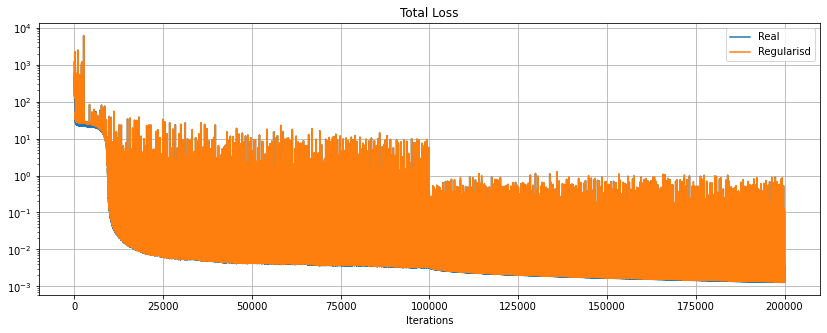

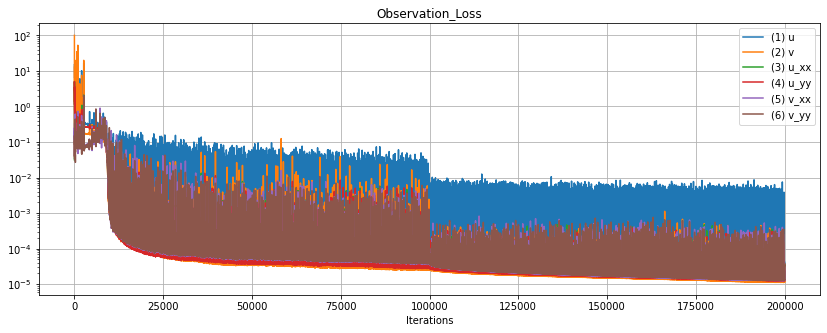

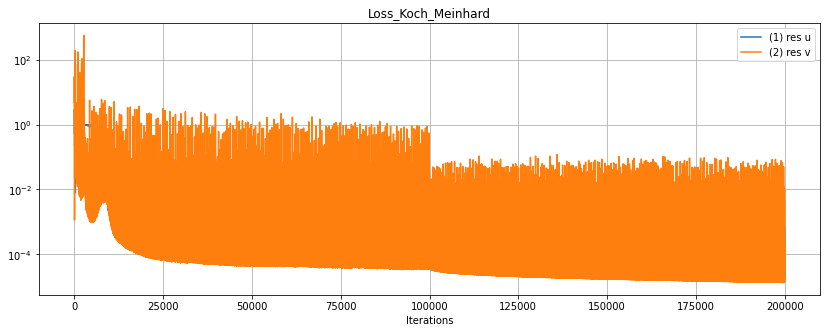

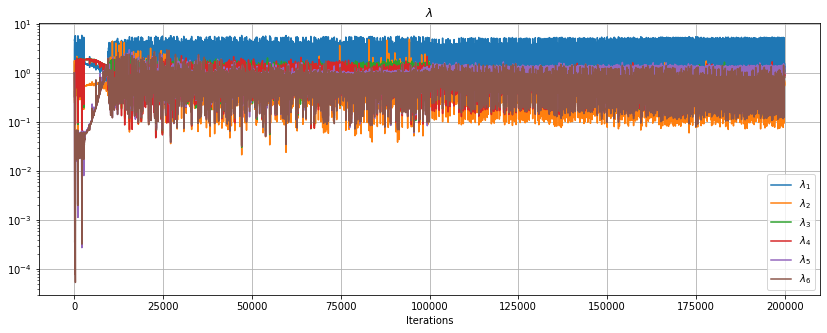

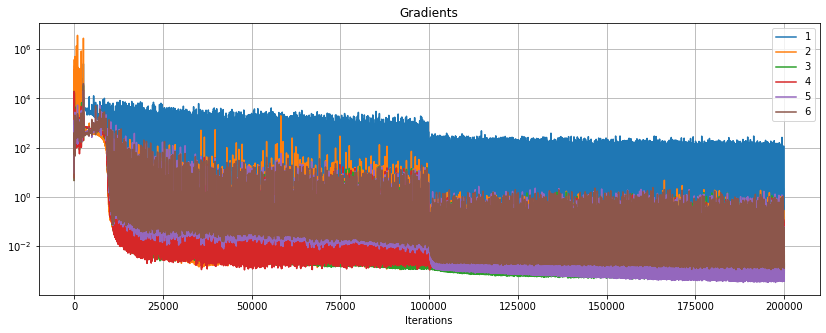

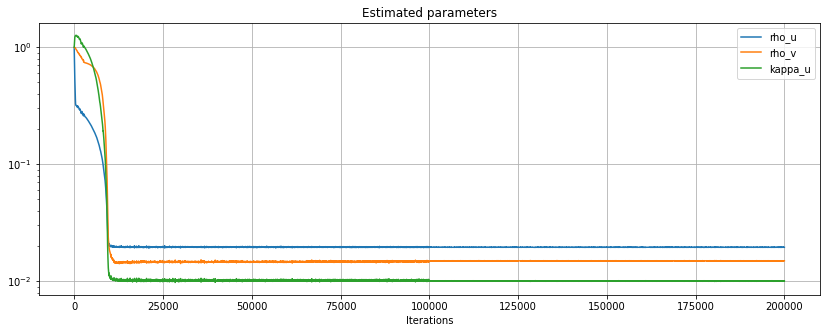

In [32]:
plot_result(merge_dict(results_KM, results_KM2, results_KM3), 
           modelKM, #y_lims=[0.02, 0.05],
            start=0, param_names=pde_resKM.parameter_names())

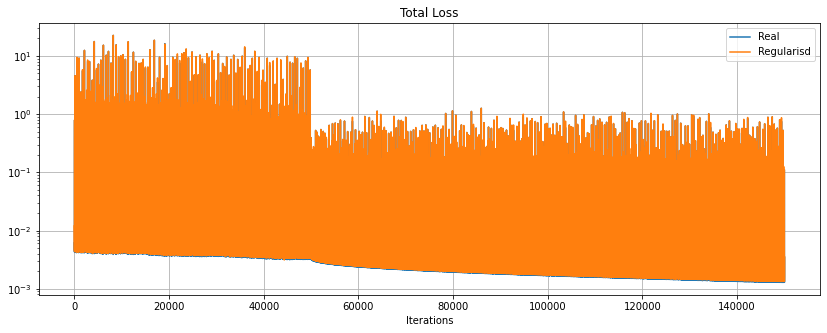

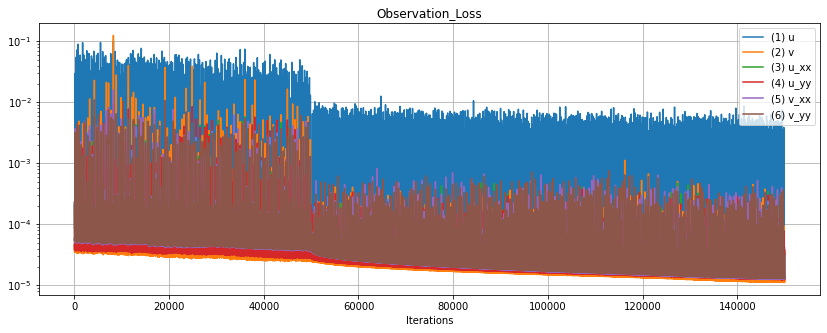

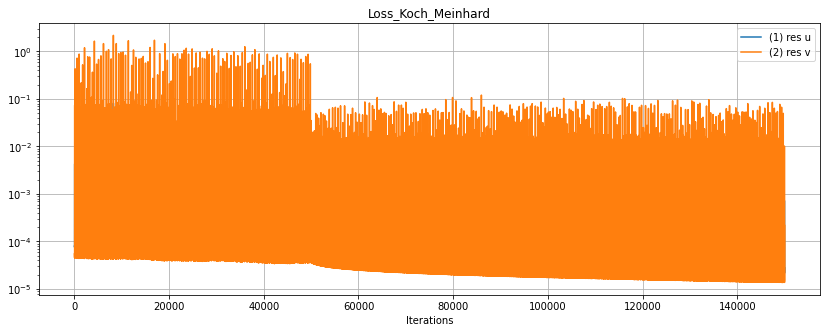

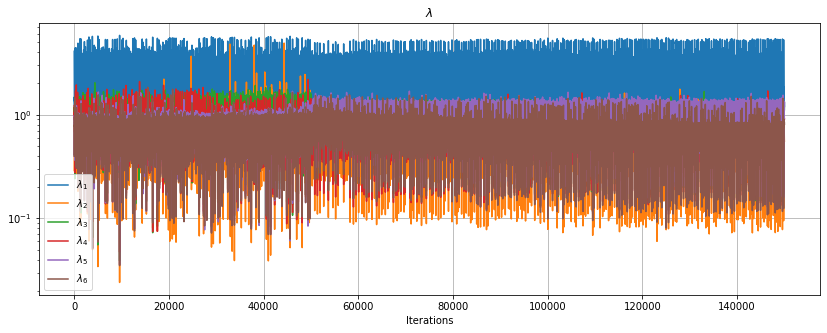

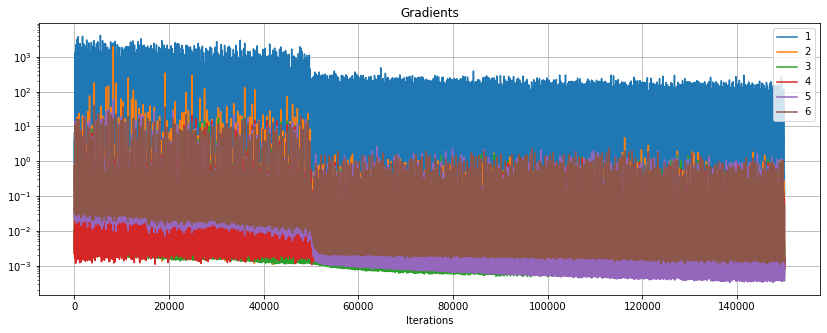

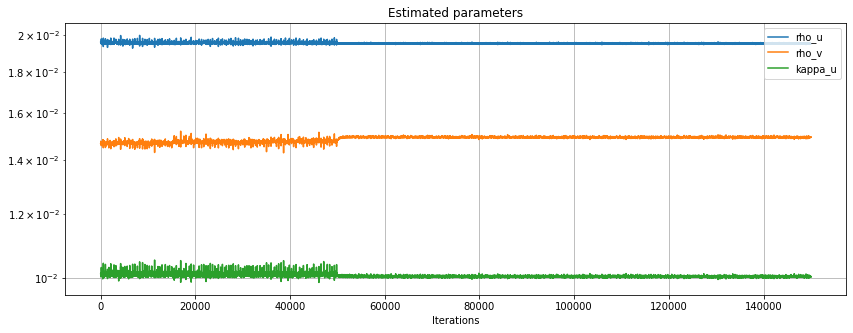

In [33]:
plot_result(merge_dict(results_KM, results_KM2, results_KM3), 
           modelKM, #y_lims=[0.02, 0.05],
            start=50000, param_names=pde_resKM.parameter_names())

In [34]:
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    D = simulation.Ds[1]/simulation.Ds[0]
    kappa_u = simulation.parameters["kappa_u"]*(simulation.parameters["sigma_u"]/simulation.parameters["mu_u"])**2
    rho_u = simulation.parameters["rho_u"]*(simulation.parameters["sigma_u"]*simulation.parameters["sigma_v"]/simulation.parameters["mu_u"]**3)
    rho_v = simulation.parameters["rho_v"]*(simulation.parameters["sigma_u"]**2/simulation.parameters["mu_u"]**3)
    
    D_2 = D
    rho_u2 = rho_u
    rho_v2 =rho_v
    kappa_u2 = kappa_u

    D = result["D"] if "D" in result.keys() else D
    rho_u = result["rho_u"] if "rho_u" in result.keys() else rho_u
    rho_v = result["rho_v"] if "rho_v" in result.keys() else rho_v
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else kappa_u
    
    
    
    return ((D-D_2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )

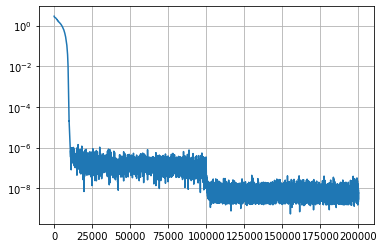

In [36]:
plt.plot(norm_params2(merge_dict(results_KM, results_KM2, results_KM3), 
             simulation))
plt.yscale('log')
plt.grid()
plt.show()

In [37]:
test_d = obs_X[:,:2].astype(np.float32)

In [38]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[2.8263197e-05, 0.00014365665]
[2.8263197e-05 1.4365668e-04]
[0.00531631 0.01198569]


In [39]:
outputs =  pinnKM.net(test_d)
#u_xx = outputs[:,0]
#u,  u_xx = (outputs[:,0], outputs[:,1])
#u, v, u_xx = (outputs[:,0], outputs[:,1], outputs[:,2])
#u, v, u_xx, v_xx = (outputs[:,0], outputs[:,1], outputs[:,2], outputs[:,3])
u, v, u_xx, u_yy, v_xx, v_yy = (outputs[:,0], outputs[:,1], outputs[:,2],
                                         outputs[:,3], outputs[:,4], outputs[:,5])

u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T


In [40]:
der_u_outputs.shape

(2450, 2)

In [41]:
np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)

1.4792832146005059e-05

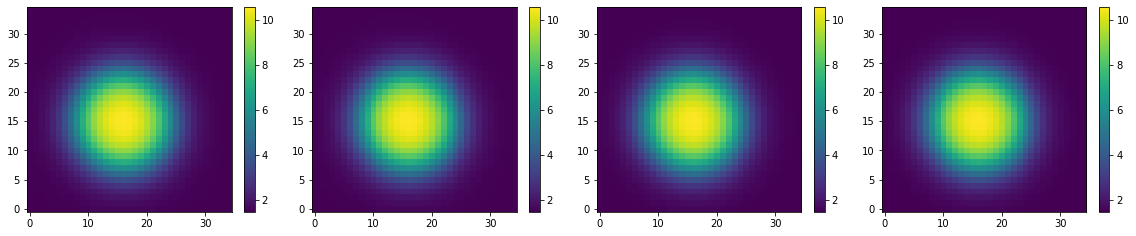

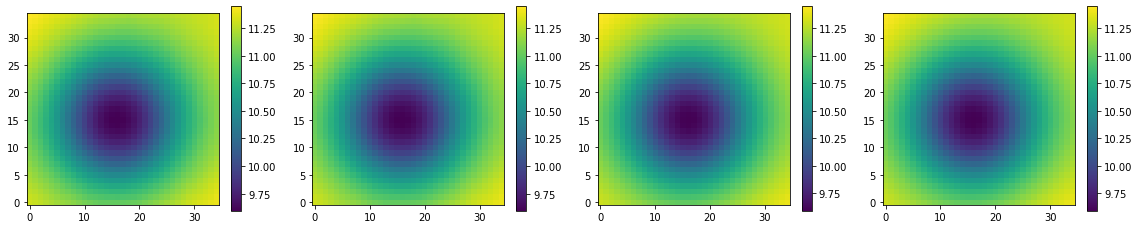

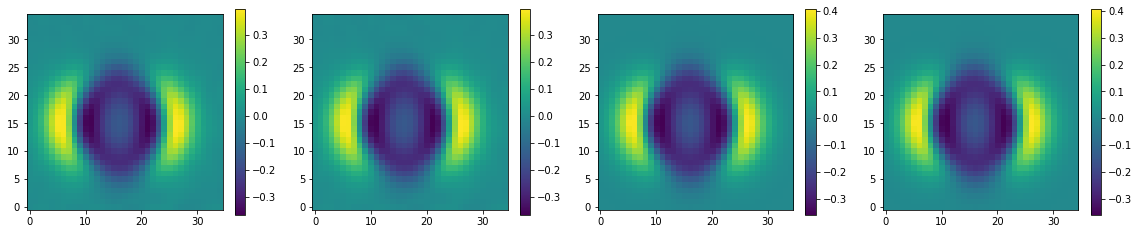

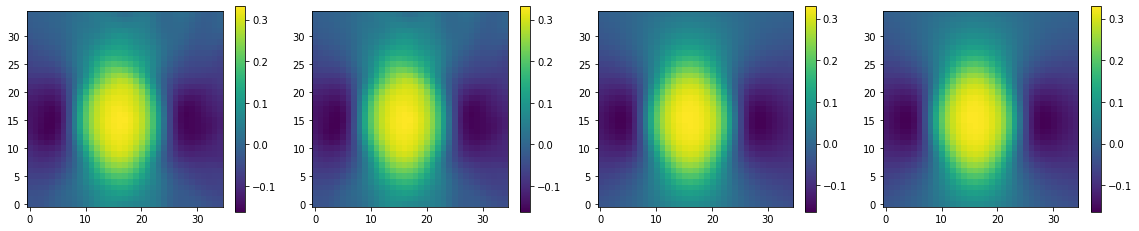

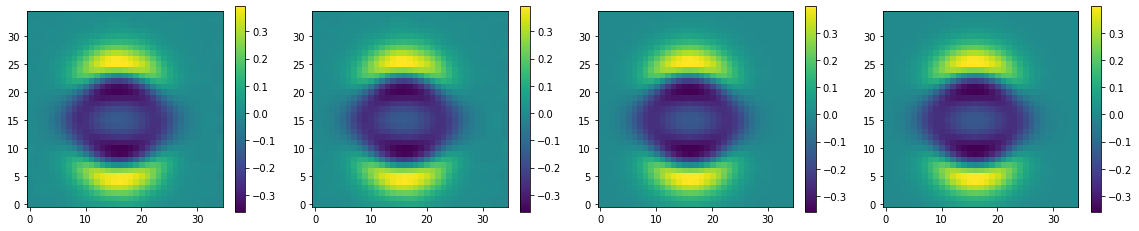

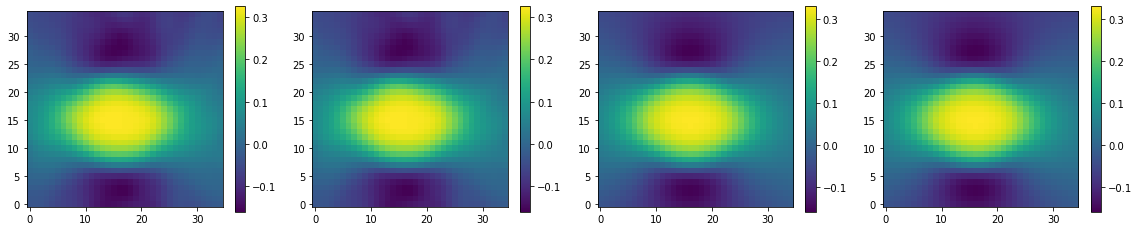

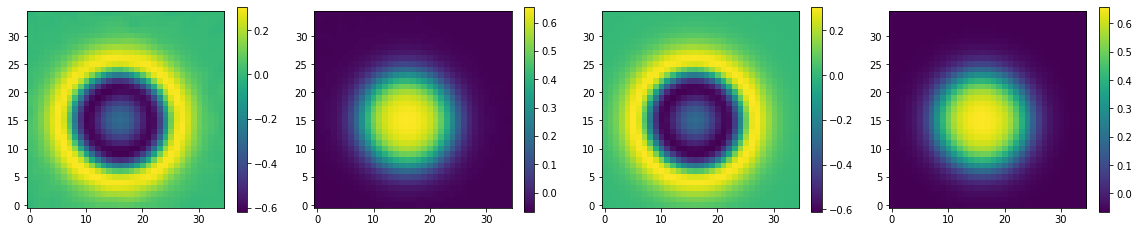

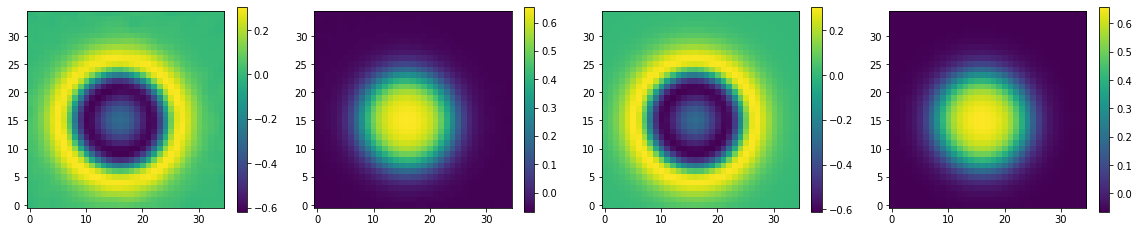

In [42]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[:block_size,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[:block_size,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[:block_size,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[:block_size,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[:block_size,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[:block_size,1])
p(u_xx1 + u_yy1, (v_xx1 + v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2 + u_yy2, (v_xx2 + v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])



In [43]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [44]:
params = np.array([rho_u, rho_v])

In [45]:
params2 = np.array([pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.rho_v.get_value(0).numpy()[0]])

In [46]:
n =  simulation.n[0]*simulation.n[1]
l = L**2
n2 = 2*block_size
u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()
kappa_sol =  pde_resKM.kappa_u.get_value(0).numpy()[0]
f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol = np.vstack((np.c_[f_sol, [0]*n2],
                   np.c_[[0]*n2, -f_sol]))

uxxyy_sol =(u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = D *  (v_xx.numpy() + v_yy.numpy()).flatten()


b_sol = np.r_[(uxxyy_sol-u_sol+1, vxxyy_sol+1+1.0)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [47]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

14.368749041761697

In [48]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

14.374139791210936

In [49]:
linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))

array([0.01951378, 0.12229032])

In [50]:
kappa_sol

0.010015052

In [51]:
params2

array([0.01951184, 0.01495548], dtype=float32)

In [52]:
params

array([0.0195, 0.015 ])

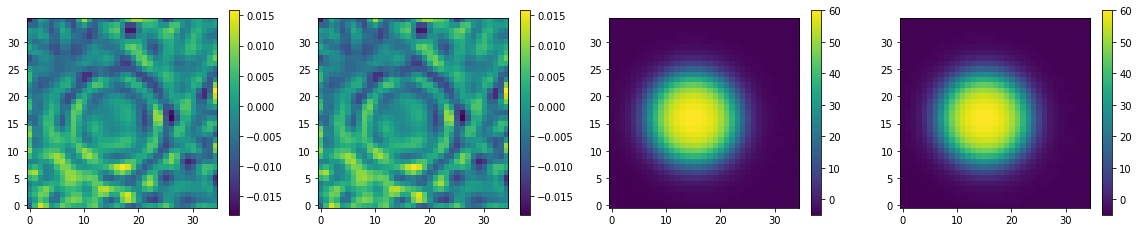

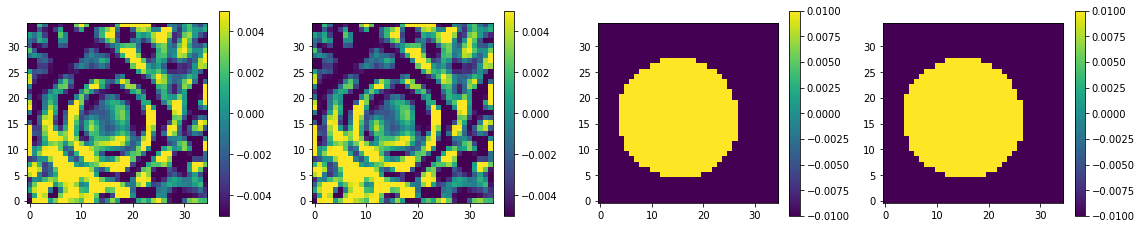

In [53]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

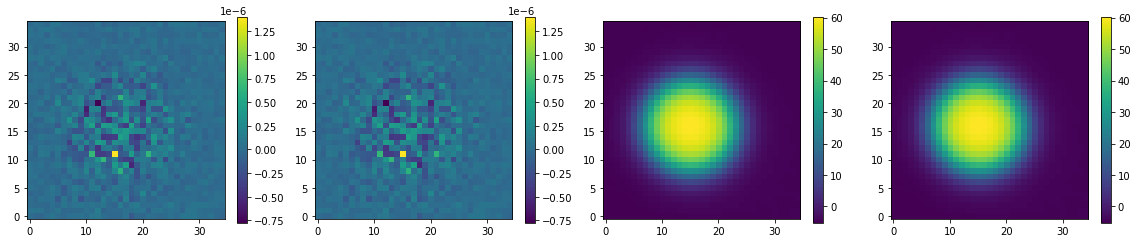

In [54]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)